Begin by importing necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Define numerical methods to solve ODEs

In [2]:
def EulerM(func, X0, params=None, tstart=0, tend=1, steps=10):
    """
    Euler Method for solving ODEs.
    
    func := function, ex.dx/dt = ax + b == params[0] * x + params[1],
    X0 := float, initial position,
    params := array, list of parameters for func,
    tstart / tend := float, starting time / ending time,
    steps := int, no. of iterations.
    """
    
    ## Initialise time vector
    ##  Calculate dt for Euler Method
    t = np.linspace(tstart,tend,steps)
    dt = abs(t[0]-t[1])
    
    ## Init. solution vector.
    ##  set initial value
    sol = np.zeros([steps])
    sol[0] = X0
    
    ## Begin Euler method
    for i in range(1, steps):
        temp = sol[i-1] + func(sol[i-1], t=t[i], params=params) * dt
        
        ## Attempt to remedy float overflow
        if abs(temp) > 1E6:
            break
        
        sol[i] = temp

    ## Return Euler solution to ODE
    return sol, i
        

def EuMa(func, X0, params=None, tstart=0, tend=1, steps=10, sigma = 3):
    """
    Euler-Maruyama Method for solving SDEs.
    
    func := function, ex.dx/dt = ax + b == params[0] * x + params[1],
    X0 := float, initial position,
    params := array, list of parameters for func,
    tstart / tend := float, starting time / ending time,
    steps := int, no. of iterations,
    sigma := float, scale for amount of noise in system.
    """
    
    ## Initialise time vector
    ##  Calculate dt for Euler Method
    t = np.linspace(tstart,tend,steps)
    dt = abs(t[0]-t[1])
    
    ## Init. solution vector.
    ##  set initial value
    sol = np.zeros([steps])
    sol[0] = X0
    
    ## Begin Euler-Maruyama method
    for i in range(1, steps):
        temp = sol[i-1] + func(sol[i-1], t=t[i], params=params) * dt + sigma * np.random.random() * (np.random.randint(0,1)*2-1)
        
        ## Attempt to remedy float overflow
        if abs(temp) > 1E6:
            break
        
        sol[i] = temp
    
    ## Return Euler-Maruyama solution to SDE
    return sol, i

For checking if bifurcation will occur in system, need to check where fixed points of system are

In [3]:
def fp_cubic(params):
    """
    Finds fixed point of cubic polynomial.
    
    params := array, list of parameters.
    
    ax^3 + bx^2 + cx + d
    a = params[0]
    b = params[1]
    etc...
    
    """
    ## Organises params for easier reading
    a = params[0]
    b = params[1]
    c = params[2]
    
    ## Uses numpy roots() to get roots of
    ##  of cubic derivative
    vals = np.roots([3*a, 2*b, c])
    
    ## Assigns left peak to xL
    ##  and right peak to xR
    xL = min(vals)
    xR = max(vals)
    
    return xL, xR

In [4]:
def get_b(a,c,fold=True):
    """
    Obtains values for parameter 'b' depending on whether
     user requires a fold bifurcation to occur or not.
     
    a,c := float, paramater for ODE,
    fold := bool, decides whether fold will occur or not.
    
    Discussed more at length in thesis (see Section: Tipping Points).
    """
    
    if fold == True:
        if c >= 0:
            return np.random.random() * (np.random.randint(0,1)*2-1)
        else:
            return (np.sqrt(3*a*c) * (1 + np.random.random())) * (np.random.randint(0,1)*2-1)
    else:
        return  np.random.random() * np.sqrt(3*a*c) * (np.random.randint(0,1)*2-1)

In [5]:
def gen_params(scale=1, fold=True):
    """
    Generates set of parameters for an ODE which does or
     does not contain a fold bifurcation depending on 'fold' value
     
    scale := float, determines the scale of the parameters.
    
    !!!WARNING!!! large scale values may cause double scalar error
                EuMa() has been adapted to avoid this but does not 
                get every case.
    """
    
    ## Set a<0 as it is the ideal case
    ##  we are analysing
    a = - np.random.random() * scale
    
    ## Checks if we need fold or not
    ##  Discussed in thesis in more depth
    if fold == True:
        c = np.random.random() * (np.random.randint(0,1)*2-1) * scale
    else:
        c = - np.random.random() * scale
        
    b = get_b(a, c, fold=fold)
    
    ## Returns parameter array for cubic.
    ##  Sets 'd=0' as it is a variable.
    return np.array([a,b,c,0])

In [6]:
def check_bifur(func, params, d_range, tol=0.9):
    """
    Checks system for bifurcations in cubic system
     in some range of values.
    
    func := function, ex.dx/dt = ax + b == params[0] * x + params[1],
    params := array, list of parameters for func,
    d_range := array, range of values for bifurcation variable 'd'    
    """
    
    xmin, xmax = fp_cubic(params)
    
    if np.iscomplex(xmin) == True or np.iscomplex(xmax) == True:
        return 0
    
    elif d_range[0]*(1+tol) < func(xmin, 0, params):
        return 1
    
    else:
        return 0

In [7]:
## Defining cubic polynomial for ODE dx/dt

f = lambda x,t,params: params[0] * x**3 + params[1] * x**2 + params[2] * x + params[3]

 Iteration  100  out of  100

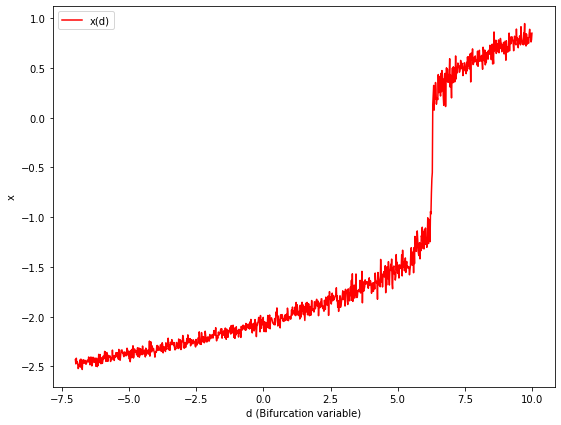

In [8]:
## Begin generating data
P = 100  ## no. of samples (P + P amount of samples)
M = 1000 ## no. of steps in solving ODE over time
N = 200  ## no. of steps in solving ODE for one time step
sample = 10 ## no. of samples taken from end of time step

## Hyper parameters for generating data
sigma = 0.06 ## Amount of noise
scale = 3 ## Scale of parameters
d_range = [-7,10] ## Range of bifur. param

## Constructs data array for bifurcation samples
data = np.zeros((P,M+1))

## Constructs lin-spaced d values used at each time step
d = np.linspace(d_range[0],d_range[1],M)

## Begins data generation process
for j in range(P):
    
    ## Generates params
    params = gen_params(scale, fold=True)
    
    ## Checks if ODE will bifurcate in this region
    data[j,0] = check_bifur(f,params,d_range,tol=0.7)
    X0 = 0
    for i in range(1,M+1):
        params[-1] = d[i-1]
        sol, n = EuMa(f, X0=X0, steps = N, params=params, sigma=sigma)
        
        if n > sample:
            data[j,i] = np.mean(sol[-sample:])
        else:
            data[j,i] = np.mean(sol[:n])
        
        X0 = data[j,i]
    
    print('\r', 'Iteration ', j+1, ' out of ', P, end='')
    
x = np.linspace(data[0,0],data[0,-1],M)

plt.figure(figsize=(9,7))
plt.plot(d,data[0,1:], 'r', label="x(d)")
plt.xlabel('d (Bifurcation variable)')
plt.ylabel('x')
plt.legend()
plt.show()

 Iteration  100  out of  100

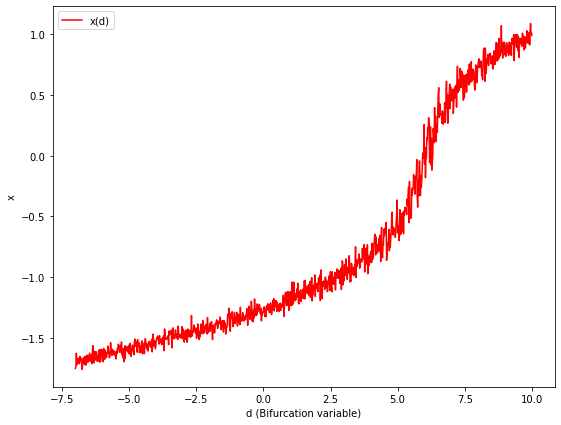

In [9]:
## Repeat above cell but for non-tipping solutions

data1 = np.zeros((P,M+1))

for j in range(P):
    params = gen_params(scale, fold=False)
    data1[j,0] = check_bifur(f,params,d_range)
    X0=-7
    for i in range(1,M+1):
        params[-1] = d[i-1]
        sol, n = EuMa(f, X0=X0, steps = N, params=params, sigma=sigma)
        
        if n > sample:
            data1[j,i] = np.mean(sol[-sample:])
        else:
            data1[j,i] = np.mean(sol[:n])
        
        
        X0 = data1[j,i]
        
    print('\r', 'Iteration ', j+1, ' out of ', P, end='')
    
    
plt.figure(figsize=(9,7))
plt.plot(d,data1[0,1:], 'r', label="x(d)")
plt.xlabel('d (Bifurcation variable)')
plt.ylabel('x')
plt.legend()
plt.show()

In [10]:
dataset = np.array([data, data1])
dataset = np.reshape(dataset, (data.shape[0] + data1.shape[0], data.shape[1]))

np.savetxt("dataset.csv", dataset, delimiter=',')